### IMPORTS

In [1]:
from Inference import BBVI 

In [2]:
import torch
import matplotlib.pyplot as plt
import _pickle as pickle

### EXAMPLE

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [4]:
# load data
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [5]:
filename = 'C:\\Users\\cortax\\Documents\\BayesianNN\\Experiments\\foong\\tanh\\MAP\\models\\' + '3Layers_50Neurons_(1)'
filehandler = open(filename, 'rb')
netparam = pickle.load(filehandler)

In [6]:
Net = BBVI.VariationalNetwork(input_size=netparam['input_size'],
                              output_size=netparam['output_size'],
                              layer_width=netparam['layer_width'],
                              nb_layers=netparam['nb_layers'])
Net.set_network(netparam)
Net.set_device(device)
Net.requires_grad_mus(False)

In [7]:
Net.compute_elbo(x_data, y_data, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()

array(2363.9934, dtype=float32)

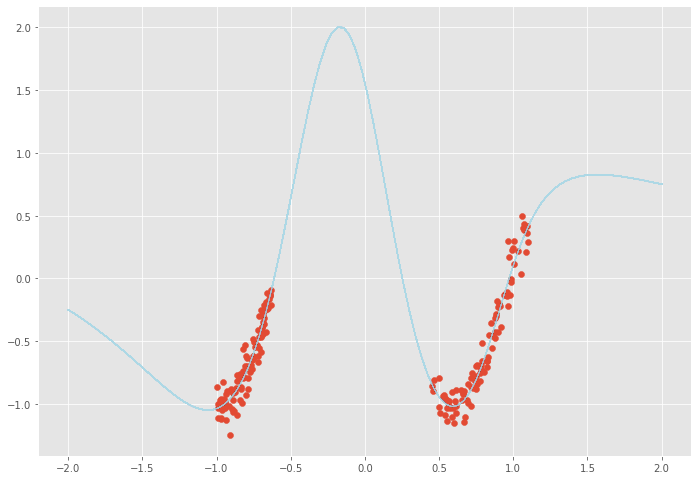

In [8]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue') 

In [ ]:
#Net.requires_grad_mus(True)

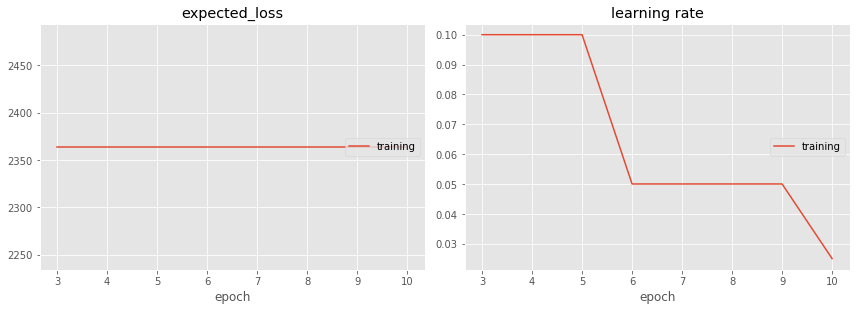

expected_loss:
training   (min: 2363.990, max: 2363.990, cur: 2363.990)

learning rate:
training   (min:    0.025, max:    0.100, cur:    0.025)


In [14]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.1}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 3, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=10, n_iter=100, n_ELBO_samples=25, plot=True)

In [10]:
n_samples_ELBO=100

In [11]:
(layered_w_samples, layered_bias_samples) = Net.sample_parameters(n_samples_ELBO)

LQ = Net.q_log_pdf(layered_w_samples, layered_bias_samples).mean()
LP = Net.prior_log_pdf(layered_w_samples, layered_bias_samples).mean()

y_pred = Net.forward(x_data)
mu = torch.flatten(y_pred, end_dim=1)
sigma = torch.eye(mu.shape[1],device=device)*torch.tensor(0.1, device=device)
nd = torch.distributions.MultivariateNormal(mu, scale_tril=sigma)

LL = nd.log_prob(torch.flatten(y_data.repeat(y_pred.shape[0], 1, 1), end_dim=1))

print(LQ)
print(LP)
print(torch.div(LL.sum(),n_samples_ELBO))

tensor(27708.5195, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(-2546.2971, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(182.3067, device='cuda:0', grad_fn=<DivBackward0>)


In [12]:
Net.compute_elbo(x_data, y_data, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()

array(2363.9905, dtype=float32)

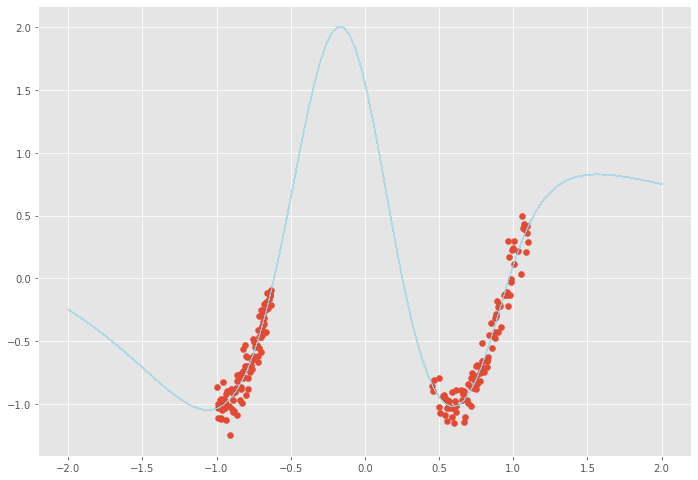

In [13]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')